In [10]:
# multivariate multi-step data preparation
from numpy import array
from numpy import hstack
import pandas as pd
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR


In [11]:
dades = read_csv('dadesSauCabals.csv', sep=';',header=0, index_col=0)

vol = dades['Volum']
tm = dades['TM']
hrm = dades['HRM']
ppt = dades['PPT']
pm = dades['PM']
ent = dades['Entrada']
sortida =  dades['Sortida']
# convert to [rows, columns] structure
vol = vol.reshape((len(vol), 1))
tm = tm.reshape((len(tm), 1))
hrm = hrm.reshape((len(hrm), 1))
ppt = ppt.reshape((len(ppt), 1))
pm = pm.reshape((len(pm), 1))
ent = ent.reshape((len(ent), 1))
sortida = sortida.reshape((len(sortida), 1))


# horizontally stack columns
dataset = hstack((vol,tm,hrm,ppt,pm, ent, sortida,vol))

scaler = MinMaxScaler(feature_range=(0, 1))
datasetN = scaler.fit_transform(dataset)

c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # This is added back by InteractiveShellApp.init_path()
c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if sys.path[0] == '':
c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  del sys.path[0]
c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
c:\users\manel\appdata\local\programs

In [12]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


In [13]:
def train_test (n_steps_in, n_steps_out, propTrainTest, dataset):
    
    n_steps_in, n_steps_out = n_steps_in, n_steps_out
    # split train test
    X, y = split_sequences(dataset, n_steps_in, n_steps_out)
    
    train_size = int(len(X) * propTrainTest)
    test_size = len(dataset) - train_size
    train_X, test_X = X[0:train_size,:], X[train_size:len(X),:]
    train_Y, test_Y = y[0:train_size,:], y[train_size:len(y),:]
    
    return (train_X, test_X, train_Y, test_Y)

In [14]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calcul global de RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [15]:
n_steps_in = 20
n_steps_out = 15
propTrainTest = 0.8
train_X, test_X, train_Y, test_Y = train_test(n_steps_in, n_steps_out, propTrainTest, datasetN)

In [16]:
# flatten input
n_input = train_X.shape[1] * train_X.shape[2]
train_X = train_X.reshape((train_X.shape[0], n_input))
test_X = test_X.reshape((test_X.shape[0], n_input))

In [17]:
from scipy.stats import uniform
from scipy.stats import randint
arbres=[]
profunditat=[]
max_features=[]
min_samples_split = []
min_samples_leaf = []
for i in range(100):
    arbres.append((randint.rvs(5, 500)))
    profunditat.append((randint.rvs(1, 121)))
    max_features.append((randint.rvs(1, 20)))
    min_samples_split.append((randint.rvs(2, 50)))
    min_samples_leaf.append((randint.rvs(1, 45)))
    


In [18]:
#Simulació RandomizedSearchCV per Random Forest
resultat=[]

for arbre, profund, max_f, mss, msl in zip(arbres, profunditat, max_features, min_samples_split, min_samples_leaf):
    regr_rf = RandomForestRegressor(n_estimators=arbre, max_depth=profund, max_features=max_f, 
                                    min_samples_split = mss, min_samples_leaf=msl, random_state=2)
    regr_rf.fit(train_X, train_Y)
    # Predict on new data
    yhat = regr_rf.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
    # invertim prediccions per tenir-les en l'escala original
    yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
    test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
    #dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    inv_yhat = scaler.inverse_transform(dataset2)
    testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
    test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
    #test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])

    RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
    print(RMSE_TOT,arbre, profund, max_f, mss, msl)
    resultat.append((arbre, profund, max_f, mss, msl, RMSE_days,RMSE_TOT))
                 
    

7.51361334709879 61 22 7 46 22
7.308671079923057 425 65 8 46 22
7.1199100540845635 334 45 19 49 16
7.117836468763846 34 23 12 18 2
7.108225819684438 259 61 19 5 27
7.288716310272261 191 103 9 46 23
7.527860017405739 498 94 3 4 2
7.233065133708089 31 115 16 4 7
8.262729686827674 495 66 3 20 22
7.285959022955221 477 53 10 28 28
7.195996918694947 169 119 13 49 7
7.149380246428932 228 55 12 33 5
7.958720682789051 477 103 5 13 41
7.8535031167805185 137 74 3 4 10
7.067669051004036 412 92 17 11 3
7.315328628153445 158 55 14 5 37
7.089004632334194 327 100 19 9 12
7.042906483609785 156 74 12 14 1
10.9672190467085 271 2 8 32 1
9.31083353419411 360 110 2 37 27
7.595659745198608 21 65 12 40 11
7.265162690074176 270 85 18 29 44
12.257055275814688 264 48 1 36 31
8.109718387623149 66 87 5 7 41
8.541804869800801 332 68 2 31 2
7.097970686073233 135 75 17 48 35
7.748601588163127 416 80 6 28 35
8.623046507399657 91 33 3 24 29
7.1926598902260235 73 12 12 49 28
7.715478458645561 253 108 7 46 42
7.093829633

In [19]:
varlist = []
for i in range(len(arbres)):
    varlist.append(resultat[i])
    
resultFinal = pd.DataFrame(varlist)
resultFinal.columns=['n_estimators','max_depth',  'max_feautres','min_samples_split','min_samples_leaf','RMSE_dies', 'RMSE_total' ]
resultFinal = resultFinal.sort_values(by='RMSE_total', ascending=True)
resultFinal = resultFinal.reset_index(drop=True)

resultFinal[0:15]

,n_estimators,max_depth,max_feautres,min_samples_split,min_samples_leaf,RMSE_dies,RMSE_total
0,156,74,12,14,1,"[3.2530749396586343, 3.9290474473533146, 4.576...",7.042906
1,410,71,18,21,19,"[3.2772409168642294, 3.983734753361578, 4.6373...",7.059308
2,455,91,18,29,19,"[3.280294580015749, 3.988264211392311, 4.64284...",7.065292
3,412,92,17,11,3,"[3.0442174666540964, 3.770100897876394, 4.4555...",7.067669
4,163,43,14,29,13,"[3.35827897523477, 4.025923331313467, 4.660209...",7.075906
5,229,59,19,3,24,"[3.312556629329939, 4.014984155780919, 4.66300...",7.078728
6,327,100,19,9,12,"[3.168425199147188, 3.897046290989891, 4.57609...",7.089005
7,373,57,16,17,8,"[3.1890185895933323, 3.9010445175997654, 4.570...",7.093830
8,135,75,17,48,35,"[3.4454037306896907, 4.110624428284051, 4.7306...",7.097971
9,150,29,14,17,16,"[3.373704041718405, 4.057934585157912, 4.69488...",7.104092


In [12]:
# Simulació GridSearchCV random forest
import numpy as np
resultatsf = []
arbres = np.arange(140,151,1)
profunditat = np.arange(85,96,1)
max_features = np.arange(5,10,1)

for arbre in arbres:
    for profund in profunditat:
        resultat = []
        for max_f in max_features:
            regr_rf = RandomForestRegressor(n_estimators=arbre, max_depth=profund, max_features=max_f, 
                                    min_samples_split = 11, min_samples_leaf=18, random_state=2)
            regr_rf.fit(train_X, train_Y)
            # Predict on new data
            yhat = regr_rf.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
            # invertim prediccions per tenir-les en l'escala original
            yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
            test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
            #dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
            dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
            inv_yhat = scaler.inverse_transform(dataset2)
            testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
            #test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
            test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])

            RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
            print(RMSE_TOT,arbre, profund, max_f)
            resultat.append((arbre, profund, max_f, RMSE_days,RMSE_TOT))

        resultatsf.append(resultat)


6.880945254786184 140 85 5
6.778934266979808 140 85 6
6.713096920783947 140 85 7
6.7109089194715965 140 85 8
6.825463452245497 140 85 9
6.880945254786184 140 86 5
6.778934266979808 140 86 6
6.713096920783947 140 86 7
6.7109089194715965 140 86 8
6.825463452245497 140 86 9
6.880945254786184 140 87 5
6.778934266979808 140 87 6
6.713096920783947 140 87 7
6.7109089194715965 140 87 8
6.825463452245497 140 87 9
6.880945254786184 140 88 5
6.778934266979808 140 88 6
6.713096920783947 140 88 7
6.7109089194715965 140 88 8
6.825463452245497 140 88 9
6.880945254786184 140 89 5
6.778934266979808 140 89 6
6.713096920783947 140 89 7
6.7109089194715965 140 89 8
6.825463452245497 140 89 9
6.880945254786184 140 90 5
6.778934266979808 140 90 6
6.713096920783947 140 90 7
6.7109089194715965 140 90 8
6.825463452245497 140 90 9
6.880945254786184 140 91 5
6.778934266979808 140 91 6
6.713096920783947 140 91 7
6.7109089194715965 140 91 8
6.825463452245497 140 91 9
6.880945254786184 140 92 5
6.778934266979808 140

6.79670780576149 145 90 9
6.8819335767751895 145 91 5
6.7692454281941545 145 91 6
6.706889364387936 145 91 7
6.711701332243134 145 91 8
6.79670780576149 145 91 9
6.8819335767751895 145 92 5
6.7692454281941545 145 92 6
6.706889364387936 145 92 7
6.711701332243134 145 92 8
6.79670780576149 145 92 9
6.8819335767751895 145 93 5
6.7692454281941545 145 93 6
6.706889364387936 145 93 7
6.711701332243134 145 93 8
6.79670780576149 145 93 9
6.8819335767751895 145 94 5
6.7692454281941545 145 94 6
6.706889364387936 145 94 7
6.711701332243134 145 94 8
6.79670780576149 145 94 9
6.8819335767751895 145 95 5
6.7692454281941545 145 95 6
6.706889364387936 145 95 7
6.711701332243134 145 95 8
6.79670780576149 145 95 9
6.880573239013803 146 85 5
6.776824134081168 146 85 6
6.70180625635798 146 85 7
6.711530111095872 146 85 8
6.790967360268027 146 85 9
6.880573239013803 146 86 5
6.776824134081168 146 86 6
6.70180625635798 146 86 7
6.711530111095872 146 86 8
6.790967360268027 146 86 9
6.880573239013803 146 87 5

In [18]:
varlist = []
for i in range(len(arbres)):
    resultatsEpDe = pd.DataFrame(resultatsf[i])
    varlist.append(resultatsEpDe)
    
resultFinal = pd.concat(varlist)

resultFinal.columns=['n_estimators','max_depth',  'max_feautres','RMSE_dies', 'RMSE_total' ]
resultFinal = resultFinal.sort_values(by='RMSE_total', ascending=True)
resultFinal = resultFinal.reset_index(drop=True)

resultFinal[0:15]

,n_estimators,max_depth,max_feautres,RMSE_dies,RMSE_total
0,140,91,8,"[3.2001843947039497, 3.748921366309714, 4.2873...",6.710909
1,140,85,8,"[3.2001843947039497, 3.748921366309714, 4.2873...",6.710909
2,140,92,8,"[3.2001843947039497, 3.748921366309714, 4.2873...",6.710909
3,140,90,8,"[3.2001843947039497, 3.748921366309714, 4.2873...",6.710909
4,140,95,8,"[3.2001843947039497, 3.748921366309714, 4.2873...",6.710909
5,140,86,8,"[3.2001843947039497, 3.748921366309714, 4.2873...",6.710909
6,140,89,8,"[3.2001843947039497, 3.748921366309714, 4.2873...",6.710909
7,140,94,8,"[3.2001843947039497, 3.748921366309714, 4.2873...",6.710909
8,140,93,8,"[3.2001843947039497, 3.748921366309714, 4.2873...",6.710909
9,140,87,8,"[3.2001843947039497, 3.748921366309714, 4.2873...",6.710909


In [19]:
regr_rf = RandomForestRegressor(n_estimators=140, max_depth=91, max_features=8, 
                                    min_samples_split = 11, min_samples_leaf=18, random_state=2)
            
regr_rf.fit(train_X, train_Y)
# Predict on new data
yhat = regr_rf.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
# invertim prediccions per tenir-les en l'escala original
yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
#dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
inv_yhat = scaler.inverse_transform(dataset2)
testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
#test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])

RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
print(RMSE_TOT)

6.7109089194715965


In [22]:
import numpy as np
import matplotlib.pyplot as plt
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - Sau - RMSE: '+str(round(RMSE_days[0],3))
title5 = '5 dies - Sau - RMSE: '+str(round(RMSE_days[4],3))
title10 = '10 dies - Sau - RMSE: '+str(round(RMSE_days[9],3))
title15 = '15 dies - Sau - RMSE: '+str(round(RMSE_days[14],3))


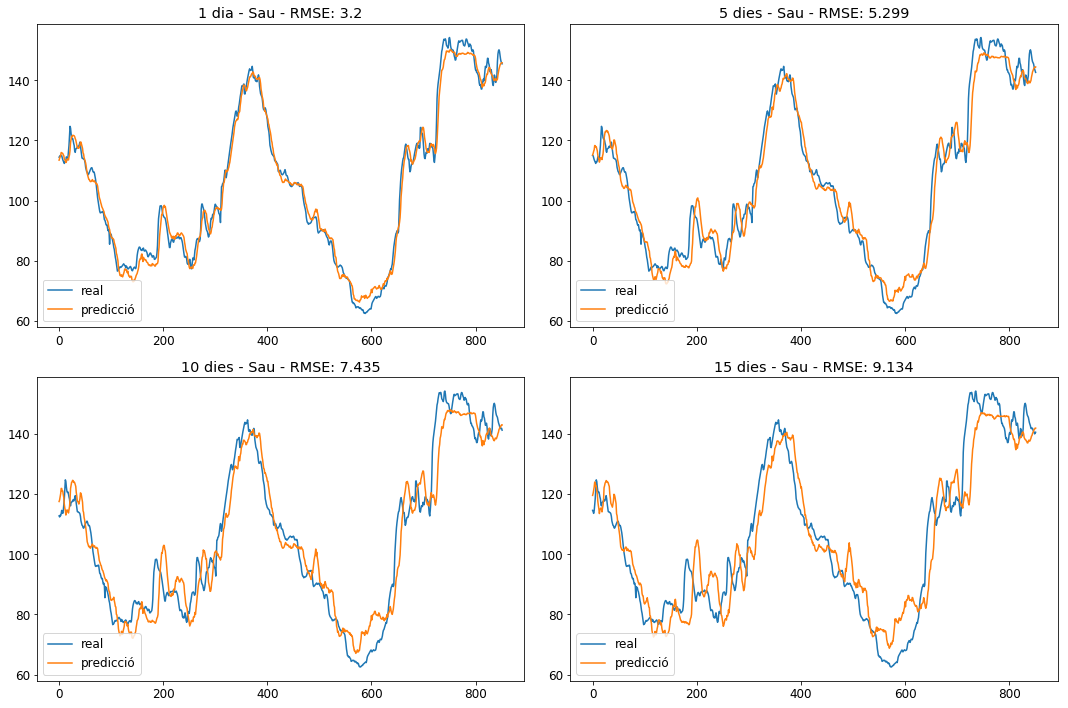

In [23]:
plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=3)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=3)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=3)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=3)


fig.tight_layout()
plt.show()